1. Use any binary classification dataset
2. Define validation strategy and use it for all next steps without changes
3. Train decision tree model and estimate performance on validation
4. Train bagging model with decision tree as a base model and estimate performance on validation
5. Write your own bagging implementation:
  <br>5.1. Define init for our CustomBaggingClassifier
  <br>5.2. Write fit as described in lecture: divide train data on n parts (`n_estimators` in CustomBaggingClassifier), train `base_estimator` on each part and save these models inside class
  <br>5.3. For predictions we should use all saved models and combine their predictions (as voting)
6. Compare performance of sklearn bagging model with your own implementation

In [29]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.base import clone
from sklearn.utils import check_random_state

import warnings
from sklearn.exceptions import ConvergenceWarning

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Suppress convergence warnings globally
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

train_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
train_raw_missing_values = train_raw.isnull().sum()
print(train_raw_missing_values[train_raw_missing_values > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [4]:
test_raw_missing_values = test_raw.isnull().sum()
print(test_raw_missing_values[test_raw_missing_values > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


In [5]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')    
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin'])

train_X = enhance_features(train_raw.drop(columns=['Survived']))
train_y = train_raw['Survived']

train_X

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_15080\1806901459.py:14: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter
PassengerId,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,7.2500,S,0,0,0,1,Mr,A/5,Unknown
2,1,female,38.000000,1,0,71.2833,C,0,0,0,0,Mrs,PC,C
3,3,female,26.000000,0,0,7.9250,S,0,0,0,1,Miss,STON/O2,Unknown
4,1,female,35.000000,1,0,53.1000,S,0,0,0,0,Mrs,,C
5,3,male,35.000000,0,0,8.0500,S,0,0,0,1,Mr,,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,13.0000,S,0,0,0,1,Rev,,Unknown
888,1,female,19.000000,0,0,30.0000,S,0,0,0,0,Miss,,B
889,3,female,29.699118,1,2,23.4500,S,1,0,0,1,Miss,W/C,Unknown


In [6]:
test_X = enhance_features(test_raw)
test_X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter
PassengerId,,,,,,,,,,,,,,
892,3,male,34.500000,0,0,7.8292,Q,0,0,0,1,Mr,,Unknown
893,3,female,47.000000,1,0,7.0000,S,0,0,0,1,Mrs,,Unknown
894,2,male,62.000000,0,0,9.6875,Q,0,0,0,1,Mr,,Unknown
895,3,male,27.000000,0,0,8.6625,S,0,0,0,1,Mr,,Unknown
896,3,female,22.000000,1,1,12.2875,S,0,0,0,1,Mrs,,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,male,29.699118,0,0,8.0500,S,1,0,0,1,Mr,A5,Unknown
1306,1,female,39.000000,0,0,108.9000,C,0,0,0,0,Dona,PC,C
1307,3,male,38.500000,0,0,7.2500,S,0,0,0,1,Mr,SOTON/OQ,Unknown


In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=1))
])

param_grid = [
  {
    "DecisionTreeClassifier__max_depth": [5, 8, 13, 20],
    "DecisionTreeClassifier__min_samples_leaf": [2, 5, 10],
    "DecisionTreeClassifier__max_leaf_nodes": [20, 50, 100],
  }
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
scoring=make_scorer(f1_score)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=12)
grid_search.fit(train_X, train_y)

print('Best_params', grid_search.best_params_)
print(f'F1 score on cross-validation: {grid_search.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search.predict(train_X), train_y)}')

Best_params {'DecisionTreeClassifier__max_depth': 13, 'DecisionTreeClassifier__max_leaf_nodes': 50, 'DecisionTreeClassifier__min_samples_leaf': 5}
F1 score on cross-validation: 0.761105594146221
F1 score on all train data: 0.8502994011976048


<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\De\AppData\Local\Temp\ipykernel_15080\3461855959.py:11: SyntaxWarning: invalid escape sequence '\P'
  os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'


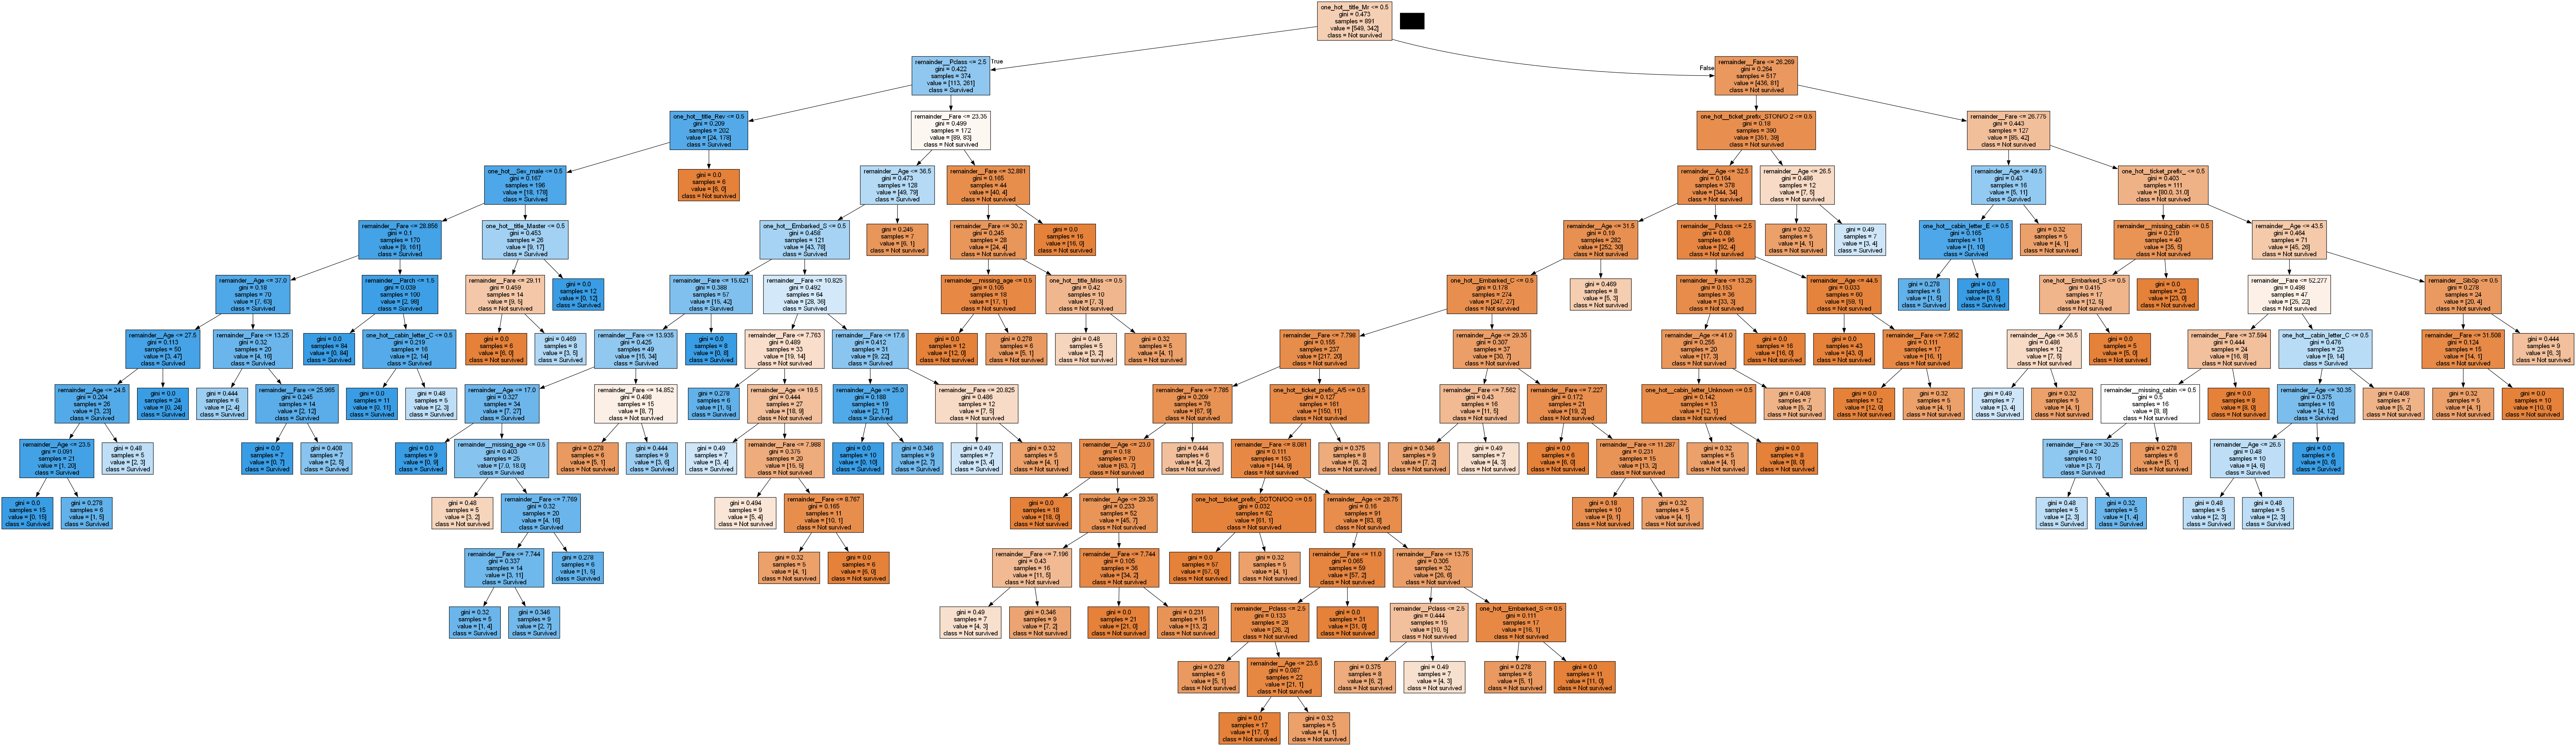

In [18]:
# pip install GraphViz
# pip install pydotplus

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO

# Windows-only fix
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'

features = grid_search.best_estimator_['Preprocessor'].get_feature_names_out()

dot_data = StringIO()
export_graphviz(
    grid_search.best_estimator_['DecisionTreeClassifier'],
    feature_names=features,
    out_file=dot_data,
    class_names=['Not survived', 'Survived'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

From the vsiaulization it's clear that Fare feature gives overfit (anchoring to minor changes in values).

It could make sense to restrict the number of minor class samples in a split, e.g don't split [1,20] node.

### Let's see if BaggingClassifier improves result for the same DT  hyperpaarmeters

In [24]:
# Take parameters from the previous step
decision_tree_classifier = DecisionTreeClassifier(random_state=1, max_depth=13, max_leaf_nodes=50, min_samples_leaf=5)

bagging_classifier = BaggingClassifier(
    decision_tree_classifier,
    random_state=3
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', bagging_classifier)
])

param_grid = {
    'BaggingClassifier__n_estimators': [50], # pick one value that's close enough to asymptote
    'BaggingClassifier__max_samples': [0.4, 0.5, 0.6], # narrowed after some experiments
    'BaggingClassifier__max_features': [0.6, 0.7, 0.8],  # narrowed after some experiments
}

grid_search2 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=12)
grid_search2.fit(train_X, train_y)


print('Best_params', grid_search2.best_params_)
print(f'F1 score on cross-validation: {grid_search2.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search2.predict(train_X), train_y)}')


Best_params {'BaggingClassifier__max_features': 0.7, 'BaggingClassifier__max_samples': 0.6, 'BaggingClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7708284112382157
F1 score on all train data: 0.8220472440944881


F1 score on cross-validation is better, overfit is less:
-  F1 score on cross-validation: 0.7708284112382157 > 0.761105594146221
- F1 score on all train data : 0.8220472440944881 < 0.8502994011976048

### Let's try to find better DT hyperparameters if DT is wrapped into BaggingClassifier

In [25]:
# Take parameters from the previous step
decision_tree_classifier = DecisionTreeClassifier(random_state=1)

bagging_classifier = BaggingClassifier(
    decision_tree_classifier,
    random_state=3
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', bagging_classifier)
])

param_grid = {
    'BaggingClassifier__estimator__max_depth':  [5, 8, 13, 20],
    'BaggingClassifier__estimator__min_samples_leaf': [2, 5, 10],
    'BaggingClassifier__estimator__max_leaf_nodes': [20, 50, 100],
    
    'BaggingClassifier__n_estimators': [50], # pick one value that's close enough to asymptote
    'BaggingClassifier__max_samples': [0.4, 0.5, 0.6], # narrowed after some experiments
    'BaggingClassifier__max_features': [0.7, 0.75, 0.8],  # narrowed after some experiments
}

grid_search2 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=12)
grid_search2.fit(train_X, train_y)


print('Best_params', grid_search2.best_params_)
print(f'F1 score on cross-validation: {grid_search2.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search2.predict(train_X), train_y)}')


Best_params {'BaggingClassifier__estimator__max_depth': 8, 'BaggingClassifier__estimator__max_leaf_nodes': 20, 'BaggingClassifier__estimator__min_samples_leaf': 2, 'BaggingClassifier__max_features': 0.7, 'BaggingClassifier__max_samples': 0.6, 'BaggingClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7853725975079305
F1 score on all train data: 0.821875


F1 score on cross-validation improves, overfit is reduced, let's use the found parameters 

In [34]:
class CustomBaggingClassifier:
    def __init__(self, estimator, n_estimators=10, max_samples=0.5, max_features=1, random_state=1): # Some default values, we'll override them later
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.random_state = random_state
        
        self.estimators_ = []
        self.features_indices_ = []
        
  
    def fit(self, X, y):        
        self.estimators_ = []
        self.samples_indices_ = []
        self.features_indices_ = []
        
        # todo: Check in the allowed range 
        n_sampled_rows = int(X.shape[0] * self.max_samples)
        n_sampled_features = int(X.shape[1] * self.max_features)
        
        rng = np.random.RandomState(self.random_state)
                
        for i in range(self.n_estimators):
            sample_indices = rng.choice(X.shape[0] , size=n_sampled_rows, replace=True)
            feature_indices = rng.choice(X.shape[1], size=n_sampled_features, replace=False)
            
            X_sample = X[sample_indices][:, feature_indices]
            y_sample = y[sample_indices]
                        
            i_estimator = clone(self.estimator)
            i_estimator.fit(X_sample, y_sample)
            
            self.estimators_.append(i_estimator)
            self.features_indices_.append(feature_indices)
            
        return
    
        
    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        for i, i_estimator in enumerate(self.estimators_):
            X_sample = X[:, self.features_indices_[i]]
            predictions[:, i] = i_estimator.predict(X_sample)
        
        majority_vote = np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(), 
            axis=1,
            arr=predictions
        )
        
        return majority_vote
    

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))
        
        for i, i_estimator in enumerate(self.estimators_):
            X_sample = X[:, self.features_indices_[i]]
            probas += i_estimator.predict_proba(X_sample)
        
        # Average the probabilities across all estimators
        return probas / self.n_estimators
    

    def get_params(self, **params):
        return {
            'estimator': self.estimator,
            'n_estimators': self.n_estimators,
            'max_samples': self.max_samples,
            'max_features': self.max_features,
            'random_state': self.random_state
        }
    
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
            
        return self

Use best parameters found with standard Bagging implementation

In [44]:
decision_tree_classifier = DecisionTreeClassifier(random_state=1, max_depth=8, max_leaf_nodes=20, min_samples_leaf=2)

custom_bagging_classifier = CustomBaggingClassifier(
    decision_tree_classifier,
    random_state=3
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', custom_bagging_classifier)
])

# Let's use the same parameters as the standard bagging found optimal
param_grid = {    
    'BaggingClassifier__n_estimators': [50],
    'BaggingClassifier__max_samples': [0.6],
    'BaggingClassifier__max_features': [0.7],
}

grid_search3 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search3.fit(train_X, train_y.to_numpy())

print('Best_params', grid_search3.best_params_)
print(f'F1 score on cross-validation: {grid_search3.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search3.predict(train_X), train_y.to_numpy())}')


Best_params {'BaggingClassifier__max_features': 0.7, 'BaggingClassifier__max_samples': 0.6, 'BaggingClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7566018495609341
F1 score on all train data: 0.8117283950617284


Much worse than standard bagging:

Cross-validation: 0.7566018495609341 < 0.7853725975079305

All train data: 0.8305343511450382 > 0.821875

### Let's try to find better hyperparameters

In [46]:

decision_tree_classifier = DecisionTreeClassifier(random_state=1, max_depth=8, max_leaf_nodes=20, min_samples_leaf=2)

custom_bagging_classifier = CustomBaggingClassifier(
    decision_tree_classifier,
    random_state=3
)

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('BaggingClassifier', custom_bagging_classifier)
])

param_grid = {    
    'BaggingClassifier__n_estimators': [50], # pick one value that's close enough to asymptote
    'BaggingClassifier__max_samples': [0.4, 0.5, 0.6], # narrowed after some experiments
    'BaggingClassifier__max_features': [0.7, 0.75, 0.8],  # narrowed after some experiments
}

grid_search4 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search4.fit(train_X, train_y.to_numpy())


print('Best_params', grid_search4.best_params_)
print(f'F1 score on cross-validation: {grid_search4.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search4.predict(train_X), train_y.to_numpy())}')


Best_params {'BaggingClassifier__max_features': 0.8, 'BaggingClassifier__max_samples': 0.5, 'BaggingClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7726380761958156
F1 score on all train data: 0.8240740740740741


Numbers are close to the standard Bagging algorithm's numbers, but with different max_features and max_samples parameters. Let's use them.
-  F1 score on cross-validation: 0.7726380761958156 ~= 0.7708284112382157
- F1 score on all train data : 0.8240740740740741 ~= 0.8220472440944881

In [47]:
dt_test_results = test_X.copy()
dt_test_results['Survived'] = grid_search.best_estimator_.predict(test_X)
dt_test_results['Survived'].to_csv('dt_test_results.csv', index=True)

dt_standard_bagging_test_results = test_X.copy()
dt_standard_bagging_test_results['Survived'] = grid_search2.best_estimator_.predict(test_X)
dt_standard_bagging_test_results['Survived'].to_csv('dt_standard_bagging_test_results.csv', index=True)

dt_custom_bagging_test_results = test_X.copy()
dt_custom_bagging_test_results['Survived'] = grid_search3.best_estimator_.predict(test_X)
dt_custom_bagging_test_results['Survived'].to_csv('dt_custom_bagging_test_results.csv', index=True)

dt_custom_bagging_test_results2 = test_X.copy()
dt_custom_bagging_test_results2['Survived'] = grid_search4.best_estimator_.predict(test_X)
dt_custom_bagging_test_results2['Survived'].to_csv('dt_custom_bagging_test_results2.csv', index=True)

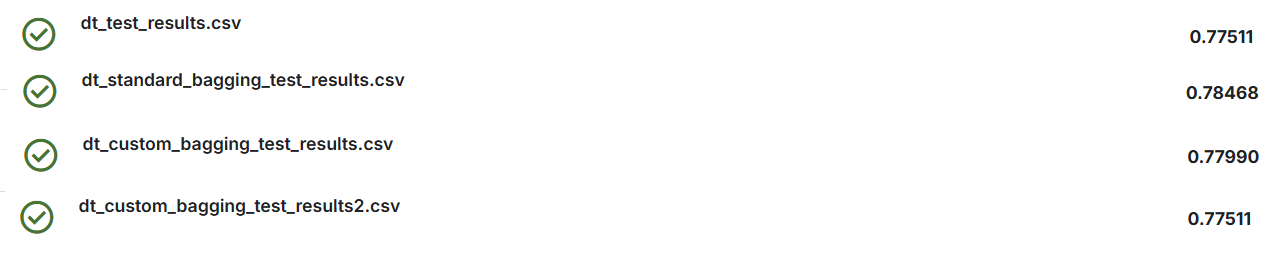

Kaggle submission gave better result for custom bagging with the same hyperparameters as standard bagging was trained.

### Find best parameters for RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state=3))
])

param_grid = {    
    'RandomForestClassifier__n_estimators': [50],
        
    'RandomForestClassifier__max_depth':  [5, 8, 13, 20],
    'RandomForestClassifier__min_samples_leaf': [2, 5, 10],
    'RandomForestClassifier__max_leaf_nodes': [20, 50, 100],
}

grid_search5 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search5.fit(train_X, train_y.to_numpy())


print('Best_params', grid_search5.best_params_)
print(f'F1 score on cross-validation: {grid_search5.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search5.predict(train_X), train_y.to_numpy())}')


Best_params {'RandomForestClassifier__max_depth': 8, 'RandomForestClassifier__max_leaf_nodes': 100, 'RandomForestClassifier__min_samples_leaf': 2, 'RandomForestClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7688172728786057
F1 score on all train data: 0.8190184049079755


In [50]:
from sklearn.ensemble import RandomForestClassifier

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state=3))
])

param_grid = {    
    'RandomForestClassifier__n_estimators': [50],
    'RandomForestClassifier__max_samples': [0.4, 0.5, 0.6],
    'RandomForestClassifier__max_features': [0.7, 0.75, 0.8],
    
    'RandomForestClassifier__max_depth':  [5, 8, 13, 20],
    'RandomForestClassifier__min_samples_leaf': [2, 5, 10],
    'RandomForestClassifier__max_leaf_nodes': [20, 50, 100],
}

grid_search5 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search5.fit(train_X, train_y.to_numpy())


print('Best_params', grid_search5.best_params_)
print(f'F1 score on cross-validation: {grid_search5.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search5.predict(train_X), train_y.to_numpy())}')


c:\Python\envs\ds1\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best_params {'RandomForestClassifier__max_depth': 8, 'RandomForestClassifier__max_features': 0.8, 'RandomForestClassifier__max_leaf_nodes': 50, 'RandomForestClassifier__max_samples': 0.4, 'RandomForestClassifier__min_samples_leaf': 2, 'RandomForestClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7721834799070785
F1 score on all train data: 0.8452012383900929


### Use parameters found earlier for standard bagging classifier in RandomForestClassifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

pipeline2 = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state=3))
])

param_grid = {    
    'RandomForestClassifier__n_estimators': [50],
    'RandomForestClassifier__max_samples': [0.6],
    'RandomForestClassifier__max_features': [0.7],
    'RandomForestClassifier__max_depth':  [8],
    'RandomForestClassifier__min_samples_leaf': [2],
    'RandomForestClassifier__max_leaf_nodes': [20],
}

grid_search6 = GridSearchCV(pipeline2, param_grid, cv=cv, scoring=scoring, n_jobs=1)
grid_search6.fit(train_X, train_y.to_numpy())

print('Best_params', grid_search6.best_params_)
print(f'F1 score on cross-validation: {grid_search6.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search6.predict(train_X), train_y.to_numpy())}')


Best_params {'RandomForestClassifier__max_depth': 8, 'RandomForestClassifier__max_features': 0.7, 'RandomForestClassifier__max_leaf_nodes': 20, 'RandomForestClassifier__max_samples': 0.6, 'RandomForestClassifier__min_samples_leaf': 2, 'RandomForestClassifier__n_estimators': 50}
F1 score on cross-validation: 0.7557626048236512
F1 score on all train data: 0.8194662480376766


In [52]:
dt_random_forest_test_results = test_X.copy()
dt_random_forest_test_results['Survived'] = grid_search5.best_estimator_.predict(test_X)
dt_random_forest_test_results['Survived'].to_csv('dt_random_forest_test_results.csv', index=True)

dt_random_forest_test_results2 = test_X.copy()
dt_random_forest_test_results2['Survived'] = grid_search6.best_estimator_.predict(test_X)
dt_random_forest_test_results2['Survived'].to_csv('dt_random_forest_test_results2.csv', index=True)

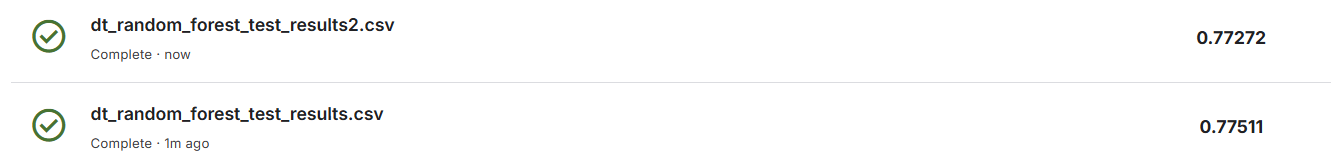

RandomForestClassifier did not improve results of bagging and has the same score as regular DT both on validation and kaggle test data!
- is it ok?
- will see if feature engineering would help (in later homeworks)